###Setup & Data Loading for DCGAN (CelebA 64x64)

Created directory: ./data


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=e7332450-708d-482c-a0ec-607aec880a16
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:24<00:00, 58.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 62.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 37.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/data/celeba/list_landm

Successfully loaded/found CelebA dataset. Number of images: 202599
Created DataLoader with batch size 128.


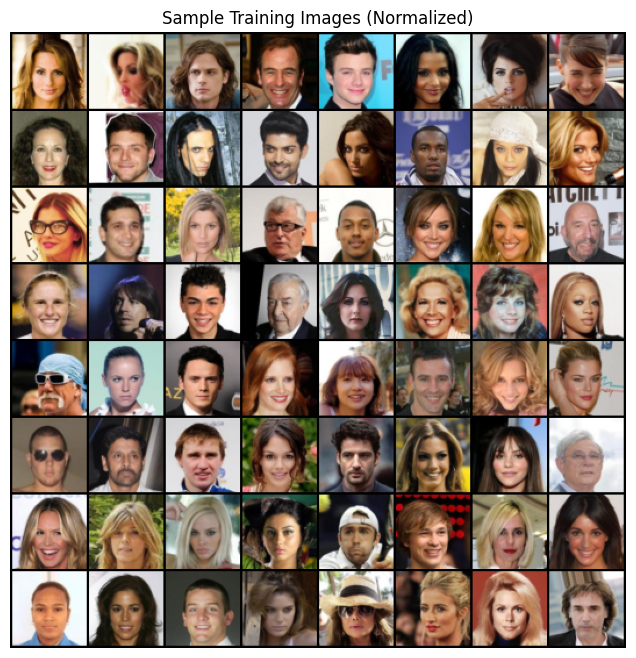

In [1]:
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Configuration ---
dataroot = "./data"  # Directory to store the dataset
image_size = 64      # Resize images to this size
batch_size = 128     # Batch size for training
workers = 2          # Number of workers for dataloader (adjust based on Colab instance)

# --- Create Dataset Directory ---
# Check if the directory exists, if not create it
if not os.path.exists(dataroot):
    os.makedirs(dataroot)
    print(f"Created directory: {dataroot}")
else:
    print(f"Directory already exists: {dataroot}")


# --- Define Image Transformations ---
# We resize to image_size, center crop to ensure it's exactly image_size,
# convert to tensor, and normalize to [-1, 1] range suitable for GANs (tanh activation).
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize R, G, B channels
])

# --- Load CelebA Dataset ---
# We will use the 'all' split for simplicity in this training part.
# download=True will attempt to download it if not found in dataroot.
# Note: CelebA is large (~1.3GB). Download might take time.
# If Colab has issues downloading via torchvision (sometimes happens due to Google Drive limits),
# you might need to manually download 'img_align_celeba.zip' and place it in the dataroot/celeba/ directory.
# Let's try the automatic download first.
try:
    dataset = dset.CelebA(root=dataroot,
                           split='all', # Use 'train', 'valid', 'test', or 'all'
                           target_type='attr', # We don't need attributes, but it's required
                           transform=transform,
                           download=True) # Set to True to attempt download
    print(f"Successfully loaded/found CelebA dataset. Number of images: {len(dataset)}")

    # --- Create DataLoader ---
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=workers)

    print(f"Created DataLoader with batch size {batch_size}.")

    # --- Visualize a Batch (Optional Verification) ---
    # Get a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot some images
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sample Training Images (Normalized)")
    # Use make_grid to arrange images; normalize=True shifts [-1,1] back to [0,1] for display
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

except Exception as e:
    print(f"Error loading or processing dataset: {e}")
    print("Potential issues:")
    print("- Check internet connection for download.")
    print("- Ensure enough disk space in Colab (~2GB needed initially).")
    print("- If automatic download fails repeatedly, consider manual download:")
    print("  1. Download 'img_align_celeba.zip' from official CelebA sources.")
    print(f" 2. Place it inside '{dataroot}/celeba/'")
    print("  3. Potentially also need annotation files like 'list_attr_celeba.txt' in the same dir.")
    print("  4. Rerun this cell with download=False if manually downloaded.")

###Generator Network Definition (DCGAN)

In [2]:
import torch
import torch.nn as nn

# Define Generator Network (DCGAN architecture)

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        """
        Initializes the Generator network.
        Args:
            nz (int): Size of the latent z vector (input noise dimension). Default=100.
            ngf (int): Size of feature maps in generator. Default=64.
                         Relates to the depth/capacity of the network.
            nc (int): Number of channels in the output image. Default=3 (for RGB).
        """
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        # We construct the generator layer by layer using nn.Sequential.
        # Input is Z, going into a convolution
        # Output size calculation for ConvTranspose2d: H_out = (H_in - 1) * stride - 2 * padding + kernel_size
        self.main = nn.Sequential(
            # Input: latent vector z (nz x 1 x 1)
            # Layer 1: ConvTranspose2d, BatchNorm, ReLU
            # Output: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Layer 2: ConvTranspose2d, BatchNorm, ReLU
            # Input: (ngf * 8) x 4 x 4 -> Output: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Layer 3: ConvTranspose2d, BatchNorm, ReLU
            # Input: (ngf * 4) x 8 x 8 -> Output: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Layer 4: ConvTranspose2d, BatchNorm, ReLU
            # Input: (ngf * 2) x 16 x 16 -> Output: (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Layer 5: Output Layer - ConvTranspose2d, Tanh
            # Input: (ngf) x 32 x 32 -> Output: (nc) x 64 x 64
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Tanh activation scales the output to the range [-1, 1], matching our normalized input data.
        )

    def forward(self, input):
        """
        Defines the forward pass of the Generator.
        Args:
            input (Tensor): Input latent vector z, shape (batch_size, nz, 1, 1).
        Returns:
            Tensor: Generated image, shape (batch_size, nc, 64, 64).
        """
        return self.main(input)

# --- Example Usage (Optional - Just to test definition) ---
if __name__ == '__main__':
    # Hyperparameters (can be adjusted later)
    latent_vector_size = 100 # nz
    generator_feature_map_size = 64 # ngf
    image_channels = 3 # nc

    # Create the generator
    netG = Generator(nz=latent_vector_size, ngf=generator_feature_map_size, nc=image_channels)

    # Print the model architecture
    print("Generator Architecture:")
    print(netG)

    # Test with a dummy input batch
    batch_size_test = 4
    test_noise = torch.randn(batch_size_test, latent_vector_size, 1, 1) # Batch of latent vectors
    fake_image = netG(test_noise)
    print(f"\nTest - Input noise shape: {test_noise.shape}")
    print(f"Test - Output image shape: {fake_image.shape}") # Should be (batch_size_test, nc, 64, 64)

Generator Architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

###Discriminator Network Definition (DCGAN)

In [3]:
import torch
import torch.nn as nn

# Define Discriminator Network (DCGAN architecture)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        """
        Initializes the Discriminator network.
        Args:
            nc (int): Number of channels in the input image. Default=3 (for RGB).
            ndf (int): Size of feature maps in discriminator. Default=64.
                         Relates to the depth/capacity of the network.
        """
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf

        # We construct the discriminator layer by layer using nn.Sequential.
        # Input is an image (nc x 64 x 64)
        # Output size calculation for Conv2d: H_out = floor((H_in + 2*padding - kernel_size) / stride) + 1
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64 image
            # Layer 1: Conv2d, LeakyReLU. No BatchNorm on the first layer.
            # Output: (ndf) x 32 x 32 feature map
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU is common in GAN discriminators

            # Layer 2: Conv2d, BatchNorm, LeakyReLU
            # Input: (ndf) x 32 x 32 -> Output: (ndf * 2) x 16 x 16
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3: Conv2d, BatchNorm, LeakyReLU
            # Input: (ndf * 2) x 16 x 16 -> Output: (ndf * 4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4: Conv2d, BatchNorm, LeakyReLU
            # Input: (ndf * 4) x 8 x 8 -> Output: (ndf * 8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5: Output Layer - Conv2d, Sigmoid
            # Input: (ndf * 8) x 4 x 4 -> Output: 1 x 1 x 1 (a single probability score)
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Sigmoid activation squashes the output to the range [0, 1], representing a probability.
        )

    def forward(self, input):
        """
        Defines the forward pass of the Discriminator.
        Args:
            input (Tensor): Input image, shape (batch_size, nc, 64, 64).
        Returns:
            Tensor: Scalar probability output, shape (batch_size, 1, 1, 1).
                    Use .view(-1) to flatten it to (batch_size) if needed for loss calculation.
        """
        return self.main(input)

# --- Example Usage (Optional - Just to test definition) ---
if __name__ == '__main__':
    # Hyperparameters (can be adjusted later)
    image_channels = 3 # nc
    discriminator_feature_map_size = 64 # ndf

    # Create the discriminator
    netD = Discriminator(nc=image_channels, ndf=discriminator_feature_map_size)

    # Print the model architecture
    print("Discriminator Architecture:")
    print(netD)

    # Test with a dummy input batch
    batch_size_test = 4
    # Create a dummy image batch with the expected dimensions
    test_image = torch.randn(batch_size_test, image_channels, 64, 64)
    prediction = netD(test_image)
    print(f"\nTest - Input image shape: {test_image.shape}")
    print(f"Test - Output prediction shape: {prediction.shape}") # Should be (batch_size_test, 1, 1, 1)
    print(f"Test - Output prediction values (example):\n {prediction.view(-1)}") # Flattened output, should be between 0 and 1

Discriminator Architecture:
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

T

###Weights Initialization

In [4]:
import torch.nn as nn

# Custom weights initialization called on netG and netD
def weights_init(m):
    """
    Initializes weights for Conv2d, ConvTranspose2d, and BatchNorm2d layers
    according to the DCGAN paper recommendations.
    Uses a Normal distribution with mean=0, std=0.02 for Conv layers,
    and Normal distribution with mean=1, std=0.02 for BatchNorm scale (weight),
    and sets BatchNorm bias to 0.

    Args:
        m (nn.Module): A module (or layer) from the network.
                       This function is typically applied using model.apply(weights_init).
    """
    classname = m.__class__.__name__
    # Check if the module has 'Conv' in its class name (catches Conv2d and ConvTranspose2d)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    # Check if the module has 'BatchNorm' in its class name (catches BatchNorm2d)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # Initialize scale (gamma)
        nn.init.constant_(m.bias.data, 0)      # Initialize shift (beta)

###Model Instantiation, Weights Initialization, Defining Loss, and Setting Optimizers

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming the Generator, Discriminator, and weights_init functions
# have been defined in previous cells.

# --- Hyperparameters from previous steps ---
# You might want to gather these in one place eventually
nz = 100  # Size of latent vector z
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
nc = 3    # Number of channels in the training images (3 for RGB)

# --- Decide which device we want to run on ---
# Check if CUDA (GPU support) is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Create the Generator ---
netG = Generator(nz, ngf, nc).to(device)

# **Apply the weights_init function** (as promised reminder!)
# Initialize weights randomly according to the function defined earlier.
netG.apply(weights_init)

# Print the Generator model summary (optional)
# print(netG)

# --- Create the Discriminator ---
netD = Discriminator(nc, ndf).to(device)

# **Apply the weights_init function** (as promised reminder!)
# Initialize weights randomly according to the function defined earlier.
netD.apply(weights_init)

# Print the Discriminator model summary (optional)
# print(netD)

# --- Loss Function ---
# Use Binary Cross Entropy loss, standard for vanilla GANs
criterion = nn.BCELoss()

# --- Optimizers ---
# As recommended in the DCGAN paper, use Adam optimizer
# with learning rate 0.0002 and Beta1 = 0.5
lr = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both Generator (G) and Discriminator (D)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Models instantiated, weights initialized, loss defined, optimizers created.")

Using device: cuda:0
Models instantiated, weights initialized, loss defined, optimizers created.


###Mounting Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Loading Saved Model

In [16]:
import torch
import os

# --- Checkpoint Loading ---
# Define the path to the checkpoint you want to load
checkpoint_path = "/content/drive/MyDrive/FINAL_PROJECT/Saved_Model/dcgan_epoch_14.pth" # Make sure this path is correct!

# Initialize variables that might be loaded
start_epoch = 0
G_losses = []
D_losses = []
iters = 0

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint: {checkpoint_path}")
    try:
        # Load the checkpoint dictionary. map_location=device ensures it loads correctly.
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load state dictionaries for models and optimizers
        # Make sure netG, netD, optimizerG, optimizerD have been created BEFORE this block
        if 'netG_state_dict' in checkpoint:
            netG.load_state_dict(checkpoint['netG_state_dict'])
            print("Loaded Generator state dict.")
        else:
            print("WARNING: Generator state dict not found in checkpoint.")

        if 'netD_state_dict' in checkpoint:
            netD.load_state_dict(checkpoint['netD_state_dict'])
            print("Loaded Discriminator state dict.")
        else:
            print("WARNING: Discriminator state dict not found in checkpoint.")

        if 'optimizerG_state_dict' in checkpoint:
            optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
            print("Loaded Generator optimizer state dict.")
        else:
            print("WARNING: Generator optimizer state dict not found in checkpoint.")

        if 'optimizerD_state_dict' in checkpoint:
            optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
            print("Loaded Discriminator optimizer state dict.")
        else:
            print("WARNING: Discriminator optimizer state dict not found in checkpoint.")

        # Load epoch number (add 1 to start from the next epoch)
        if 'epoch' in checkpoint:
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
        else:
            print("WARNING: Epoch number not found in checkpoint, starting from epoch 0.")
            start_epoch = 0 # Ensure it's 0 if not found

        # Load loss history and iterations AFTER loading checkpoint dict
        if 'G_losses' in checkpoint and 'D_losses' in checkpoint:
            G_losses = checkpoint['G_losses']
            D_losses = checkpoint['D_losses']
            print(f"Loaded previous loss history ({len(G_losses)} entries).")
        else:
            print("Loss history not found in checkpoint. Starting new lists.")
            G_losses = []
            D_losses = []

        if 'iters' in checkpoint:
             iters = checkpoint['iters'] # Load previous iteration count
             print(f"Loaded previous iteration count: {iters}")
        else:
             iters = 0 # Ensure it's 0 if not found

        # Make sure models are in training mode after loading state_dict
        netG.train()
        netD.train()

    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting training from scratch.")
        start_epoch = 0
        iters = 0
        G_losses = []
        D_losses = []
        # Ensure models are initialized if not loading checkpoint (weights_init was already applied in setup)
        # If you had issues, might need to re-init here, but setup should cover it.

else:
    # Checkpoint file does not exist, initialize everything from scratch
    print(f"Checkpoint file not found at {checkpoint_path}.")
    print("Starting training from scratch (epoch 0).")
    start_epoch = 0
    iters = 0
    G_losses = []
    D_losses = []
    # Ensure models have initial weights (weights_init was applied in setup cell)

Loading checkpoint: /content/drive/MyDrive/FINAL_PROJECT/Saved_Model/dcgan_epoch_14.pth
Loaded Generator state dict.
Loaded Discriminator state dict.
Loaded Generator optimizer state dict.
Loaded Discriminator optimizer state dict.
Resuming training from epoch 14
Loaded previous loss history (22162 entries).
Loaded previous iteration count: 22162


###Main Training Loop (DCGAN)

In [17]:
import time
import torchvision.utils as vutils
import os # For saving checkpoints

# --- Training Loop Hyperparameters ---
num_epochs = 15
print_freq = 100 # How often to print status (every X batches)
# Checkpoint saving
save_checkpoints = True
checkpoint_dir = "/content/drive/MyDrive/FINAL_PROJECT/Saved_Model" # Directory to save checkpoints
checkpoint_freq = 1 # Save every X epochs
if save_checkpoints and not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# --- Fixed Noise for Visualization ---
# Create a batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Use 64 images for visualization grid

# --- Establish convention for real and fake labels during training ---
real_label = 1.
fake_label = 0.

# --- Lists to keep track of progress ---
img_list = []

print("Starting Training Loop...")
# For each epoch
start_time = time.time()
for epoch in range(start_epoch, num_epochs):
    epoch_start_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device) # data[0] contains the images
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1) # Flatten output to (batch_size)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item() # Average D output for real images (want this near 1)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label) # Reuse label tensor, fill with fake labels (0)
        # Classify all fake batch with D.
        # Use .detach() to avoid backprop through G here (we only update D now)
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item() # Average D output for fake images before D update (want this near 0)
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants discriminator to think fakes are real (label=1)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # IMPORTANT: Do NOT use .detach() on 'fake' here, we need gradients for G
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item() # Average D output for fake images after D update, before G update (want this near 1)
        # Update G
        optimizerG.step()

        # --- Output training stats ---
        if i % print_freq == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # --- Save Losses for plotting later ---
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # --- Check how the generator is doing by saving G's output on fixed_noise ---
        # Generate images only once per print cycle or end of epoch for efficiency
        if (iters % print_freq == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_vis = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_vis, padding=2, normalize=True))

        iters += 1

    # --- End of Epoch ---
    epoch_end_time = time.time()
    print(f"Epoch {epoch+1} finished in {epoch_end_time - epoch_start_time:.2f} seconds.")

    # --- Save Checkpoint (Optional but Recommended) ---
    if save_checkpoints and (epoch + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"dcgan_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
            'fixed_noise': fixed_noise,
            'iters': iters
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")


end_time = time.time()
print(f"Training finished in {(end_time - start_time)/60:.2f} minutes.")

Starting Training Loop...
[15/15][0/1583]	Loss_D: 0.1251	Loss_G: 4.3676	D(x): 0.9364	D(G(z)): 0.0524 / 0.0232
[15/15][100/1583]	Loss_D: 0.2290	Loss_G: 5.3639	D(x): 0.9752	D(G(z)): 0.1658 / 0.0076
[15/15][200/1583]	Loss_D: 0.1025	Loss_G: 4.9483	D(x): 0.9773	D(G(z)): 0.0729 / 0.0121
[15/15][300/1583]	Loss_D: 0.0888	Loss_G: 4.1064	D(x): 0.9507	D(G(z)): 0.0350 / 0.0287
[15/15][400/1583]	Loss_D: 0.3221	Loss_G: 2.4945	D(x): 0.8405	D(G(z)): 0.1102 / 0.1163
[15/15][500/1583]	Loss_D: 0.2265	Loss_G: 3.0701	D(x): 0.8770	D(G(z)): 0.0643 / 0.0728
[15/15][600/1583]	Loss_D: 0.1355	Loss_G: 3.8037	D(x): 0.9375	D(G(z)): 0.0519 / 0.0423
[15/15][700/1583]	Loss_D: 0.1905	Loss_G: 2.7813	D(x): 0.8653	D(G(z)): 0.0322 / 0.0971
[15/15][800/1583]	Loss_D: 0.1340	Loss_G: 4.0019	D(x): 0.9066	D(G(z)): 0.0280 / 0.0336
[15/15][900/1583]	Loss_D: 0.2671	Loss_G: 2.2543	D(x): 0.8436	D(G(z)): 0.0606 / 0.1580
[15/15][1000/1583]	Loss_D: 0.1431	Loss_G: 4.0548	D(x): 0.9396	D(G(z)): 0.0656 / 0.0301
[15/15][1100/1583]	Loss_D: 0.

###Plotting and Visualization

Attempting to visualize results...
Number of saved image grids in img_list: 17


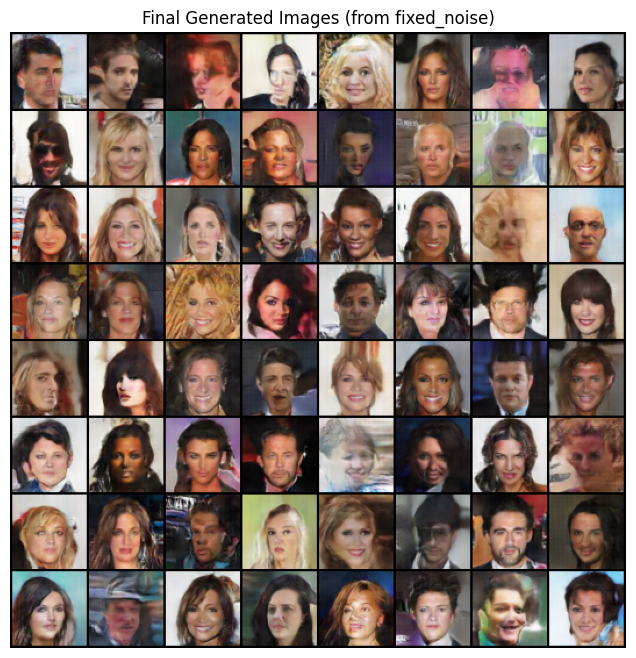

Plotting 23745 loss values...


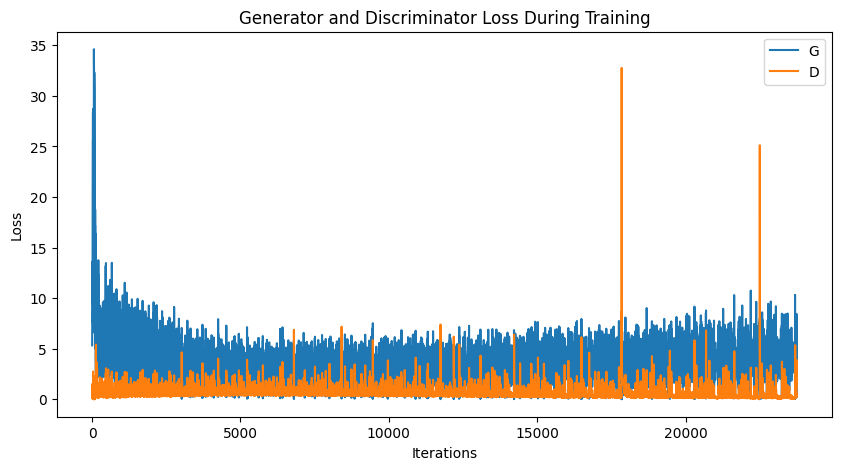

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils # Make sure vutils is imported if not already

print("Attempting to visualize results...")

# --- Visualize Generated Images ---
if 'img_list' in locals() and len(img_list) > 0:
    print(f"Number of saved image grids in img_list: {len(img_list)}")
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Final Generated Images (from fixed_noise)")
    # Display the last image grid stored in img_list
    # Need np.transpose to convert tensor C H W format to H W C for matplotlib
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

    # Optional: View earlier images by changing the index, e.g., img_list[0]
    # plt.figure(figsize=(8,8))
    # plt.axis("off")
    # plt.title("Generated Images (First Saved Grid)")
    # plt.imshow(np.transpose(img_list[0],(1,2,0)))
    # plt.show()

else:
    print("Variable 'img_list' not found or is empty. Cannot visualize images.")
    print("Ensure the training loop cell finished and populated 'img_list'.")


# --- Plot Loss Curves ---
if 'G_losses' in locals() and 'D_losses' in locals() and len(G_losses)>0:
    print(f"Plotting {len(G_losses)} loss values...")
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("Loss history variables ('G_losses', 'D_losses') not found or are empty.")
    print("Ensure the training loop cell finished and populated these lists.")